<a href="https://colab.research.google.com/github/blueeagle100/stereo_vision_starter/blob/main/kitti_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KITTI Stereo Vision**

In this notebook we will explore stereo vision through example by using raw city driving data from the [KITTI](http://www.cvlibs.net/datasets/kitti/raw_data.php) dataset. This tutorial will be extremely high level, but it will provide a bird's eye view of stereo vision. 


A readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



## **Stereo Vision Basics - Optional**

This section provides a basic background for stereo vision. It is not required to complete the tutorial but it
 will help provide a basic understanding. If you just want to learn how to make some cool videos feel free to skip it.

<br>

The image below illustrates what is called parallel stereo vision, where the images have been [rectified](https://en.wikipedia.org/wiki/Image_rectification). (We will only be working with rectified images in this tutorial).

<font color='white'>parallel camera translation</font> 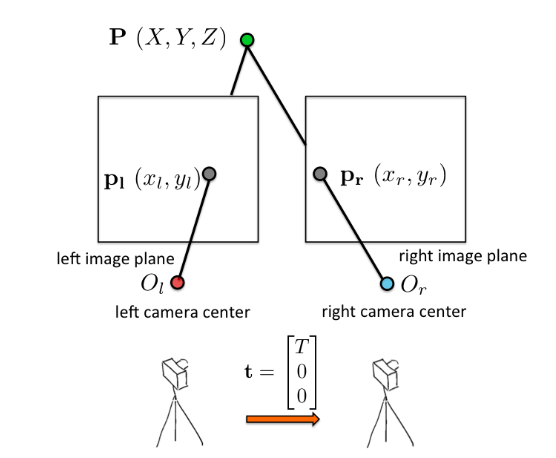


<p align="center">
    <br>
    <em> <b> Figure 1. Basic Parallel Stereo Vision Scenario. </b> </em>
</p>


The object at point P is projected to the images captured by each camera. We can see that the image location (perspective) of the object is different for each camera, this is called the disparity. If the images have been rectified, an object location on the left image will have the same y-value location on the right image. The only difference in location will be the x-value. This is why image rectification is needed, it makes the math much easier! This leads to a formal definition of disparity, it is simply the difference between left image x-location and right image x-location.

<br>
$$ d = x_l - x_r $$
<br>
$$\text{NOTE: } x_l \text{ and } x_r \text{ are pixel locations referenced from each camera's origin.}$$

Finding the matching pixel locations in each image is known as [stereo matching](https://www.cs.cmu.edu/~16385/s17/Slides/13.2_Stereo_Matching.pdf). It is a complex problem that we will learn about in a later tutorial.




### **So how do we compute the depth?**

Let's take a look at this image from these [lecture notes](http://www.cs.toronto.edu/~fidler/slides/2015/CSC420/lecture12_hres.pdf).

<font color='white'>depth computation</font>  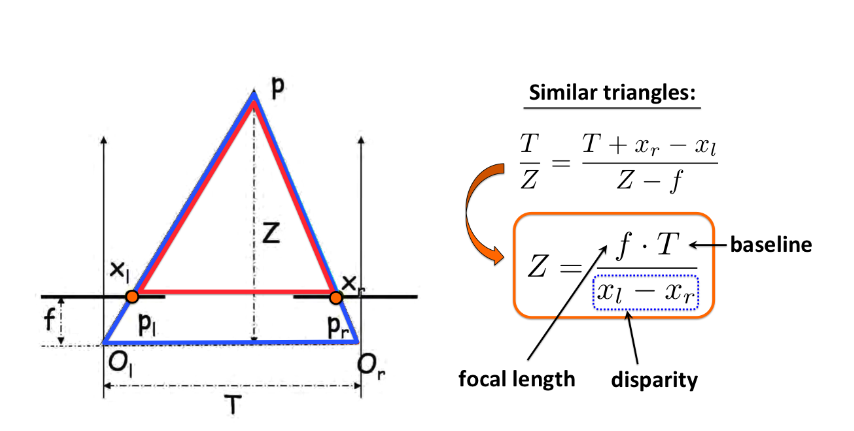



<p align="center">
    <br>
    <em> <b> Figure 2. Parallel Stereo Depth Computation  </b> </em>
</p>

The image above illustrates how triangluation is used to measure the depth of an object using images from the 2 cameras. In stereo vision, triangulation is the process of determing a 3D point using it's location in 2 or more images. The equation for finding the distance based on the disparity is presented above, but a more complete derivation can be found [here](https://johnwlambert.github.io/stereo/).

The Distance between the 2 cameras is known as the Baseline (or base). The focal length is the distance between the camera lense and image center, and it is typically assumed that it is the same for both cameras. The focal length will impact where the object is projected on each image and is therefore necessary for the depth computation. 

The computed depth Z has the same units as the baseline. Remember that the disparity is in units of pixels, so the means that the focal length must also be in units of pixels for them to cancel eachother out. To get focal length in units of pixels we can do the following computation:

$$ F_{pixels}  =  F_{mm} * \frac{\text{ImageWidth}_{pixels}}{\text{SensorWidth}_{mm}} $$

Where Image Width and Sensor Width are parameters, where Sensor Width may need to be [computed](https://www.ni.com/en-us/support/documentation/supplemental/18/calculating-camera-sensor-resolution-and-lens-focal-length.html#section--23253415https://www.ni.com/en-us/support/documentation/supplemental/18/calculating-camera-sensor-resolution-and-lens-focal-length.html#section--23253415)
<br>

**Takeaway:** <br>
The disparity is proportional to the baseline camera distance and is also inversely proportional to depth. So computing the disparity is the key to computing the depth.

### **One final concept**
To get data from our image to the 3D world (Euclidean Space) and vica versa we need a 3x4 [projection matrix](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/EPSRC_SSAZ/node3.html). See [also](https://en.wikipedia.org/wiki/Camera_matrix). The camera projection matrix is derived from the [pinhole cameral model](https://en.wikipedia.org/wiki/Pinhole_camera_model). Understanding these concepts is very involved and we will cover this in a future tutorial.

### **Download the Data**
Now that we have covered a bit of background let's get started! First we will download some data from the KITTI dataset and access it in the collab environment. I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified. In a future tutorial we will discuss why this is important, for now we will explore the data at a high level.

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-28 16:29:48--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.153
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  32.0MB/s    in 29s     

2022-08-28 16:30:18 (30.8 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains a 3x4 projection matrix.

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-28 16:30:18--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.123
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-28 16:30:18 (256 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [ ]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [ ]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. 

We will focus on the data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Get data

In [ ]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")

Number of left images: 227
Number of right images: 227


### Visualize the data

In [ ]:
index = 80

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

print(f"The shape of an image is: {left_image.shape}")

The shape of an image is: (375, 1242, 3)


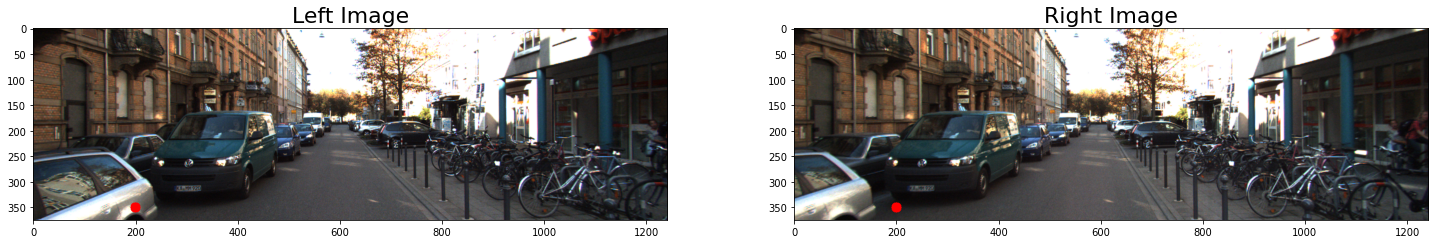

In [ ]:
# draw a point of interest 
location = (200, 350)

cv2.circle(left_image, location, 10, [255, 0, 0], -1)
cv2.circle(right_image, location, 10, [255, 0, 0], -1)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

Both images look very similar but there are subtle differences.

In the left image at the location (200, 350) we see a point on the silver car just above the wheel well. If we look at this same location in the right image, we only see paved road. We can see that the same corresponding point of the silver car is actually shifted to the left by several pixels. 

This difference in object location between the left and right images is known as the disparity. Disparity is inversly proportional to depth and is sometimes misnomered as depth. We can use disparity (along with a few other things) to compute object depth in stereo vision!

Now let's take a look at another point that's located further away.

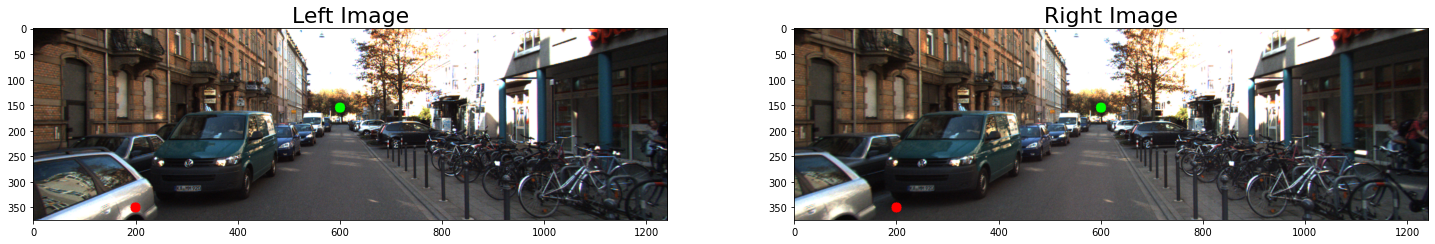

In [ ]:
# draw a point of interest 
location_2 = (600, 155)

cv2.circle(left_image, location_2, 10, [0, 255, 0], -1)
cv2.circle(right_image, location_2, 10, [0, 255, 0], -1)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

In this case the location of interest in both images is far away from the camera. In both images the point practically corresponds to the same location (right at the tree trunk). This illustrates that fact that disparity is less intense as you go further in depth. (i.e. disparity is inversely proportional to depth). 

You can actually visualize disparity yourself by holding an object in front of your face and quickly switch opening/closing our left and right eyes. You will see that the object jumps to the left and right as you hold it close, but as you extend it further away you will see less and less of a jump. Go ahead, try it!


Another thing to keep in mind is that the error of stereo depth estimation grows quadratically with depth [1](https://arxiv.org/pdf/1812.07179.pdf). We will put this statement to the test later in the next tutorial by using LiDAR point clouds as the true depth of our objects.

### Now let's compute a disparity map for the entire image!

We will now compute the disparity using opencv. The alogirthm we are using is called Stereo SGBM (Semi Global Matching). You can read more about the theory [here](https://core.ac.uk/download/pdf/11134866.pdf). The opencv documentation is located [here](https://docs.opencv.org/3.4/d1/d9f/classcv_1_1stereo_1_1StereoBinarySGBM.html). 

A note on some of the inputs to 'compute_sgbm_disparity':
 - The number of disparities refers to the greatest number of pixels that can be considered for a disparity measurement
 - The Block Size is an odd number that represents the width of the search window used for block matching pixels

In [ ]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity

In [ ]:
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

##### Now we will use an interactive display to help tune our disparity parameters

In [ ]:
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

disparity = interactive(compute_sgbm_disparity, 
                        left_image=fixed(left_image_gray), 
                        right_image=fixed(right_image_gray), 
                        num_disparities=(0,512,16), 
                        block_size=(1,19,2), 
                        window_size=(1,13,2),
                        display=fixed(True))
display(disparity)

interactive(children=(IntSlider(value=80, description='num_disparities', max=512, step=16), IntSlider(value=11…

After playing with the parameters we can take note of the combination that gives us the best results. Notice the dark region to the right, this is due to the number of disparities we have selected, the greater the number the larger this region becomes. Also notice the abrupt dark regions in our depth map, this is noise and it impact our depth estimates. The disparity map can be noised but we will press on since we want to focus on stereo vision. More robust deep learning based approachs can compute better disparity maps with less noise.

In [ ]:
num_disparities = disparity.kwargs['num_disparities']
block_size = disparity.kwargs['block_size']
window_size = disparity.kwargs['window_size']

In [ ]:
disparity = compute_sgbm_disparity(left_image_gray, 
                                   right_image_gray, 
                                   num_disparities, 
                                   block_size, 
                                   window_size, 
                                   display=False)

### Now let's compute the depth map

Now we are ready to compute the depth map, but first we will need to get the 3x4 rectified projection matrix from our calibration data

In [ ]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

print('left projection matrix')
print(P_left)

print()
print('right projection matrix')
print(P_right)

left projection matrix
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]

right projection matrix
[[ 7.215377e+02  0.000000e+00  6.095593e+02 -3.395242e+02]
 [ 0.000000e+00  7.215377e+02  1.728540e+02  2.199936e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  2.729905e-03]]


For the the left and right images, we will need to decompose the camera projection matrix into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

 See these [slides](https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf) for more details.

Also take a look at this [video tutorial](https://www.youtube.com/watch?v=S-UHiFsn-GI&list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&index=1)

For now we will use opencv to handle this.

In [ ]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

Here's the formula to compute depth

z = depth (meters)
<br>
d = disparity (pixels)
<br>
T = baseline (meters) &#8594; camera separation on the X-axis (assume cameras are aligned on the Y-axis)
<br>
f = focal length of the cameras (pixels) &#8594; assume equal focal length for each camera

<br>
<br>

$$ z = \frac{f \cdot T}{d} $$

In [ ]:
def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5
    
    # Calculate the depths 
    depth_map = f*b / disp_left 

    return depth_map

In [ ]:
# decompose the projection matrices

K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [ ]:
K_left

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

### Now let's compute the depth map!

In [ ]:
depth_map = calc_depth_map(disparity, K_left, T_left, T_right)

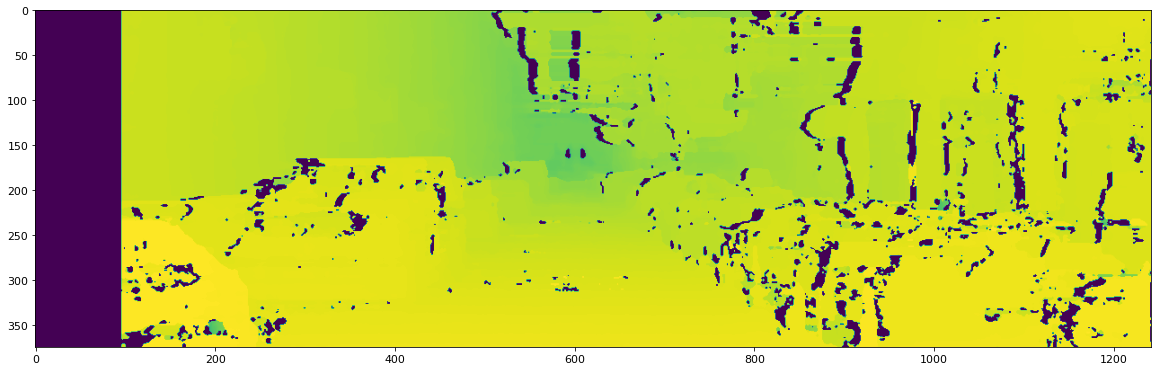

In [ ]:
# we need to take the log of the depth map in order to properly visualize it
plt.imshow(np.log(depth_map), cmap='viridis_r'); # or 'cividis_r' or 'cividis'

Here we can visualize the depth map. Click on the image to zoom in. The differences between object distances are very subtil and become less defined as we go further back.

Once again, notice the large amount of noise in our depth map (dark regions). This noise will have an impact in our depth estiamtes, to help reduce some of the noise we will use a Median Blur filter. This is effective since the noise is fairly abrupt (i.e. extremely small values randomly imposed on the depth map. We will see that taking the median of a depth window will help us get better depth estimates. For a more robust method of denoising please see this [paper](https://www.mariofrank.net/paper/frank_filteranalysis_OE09.pdf)

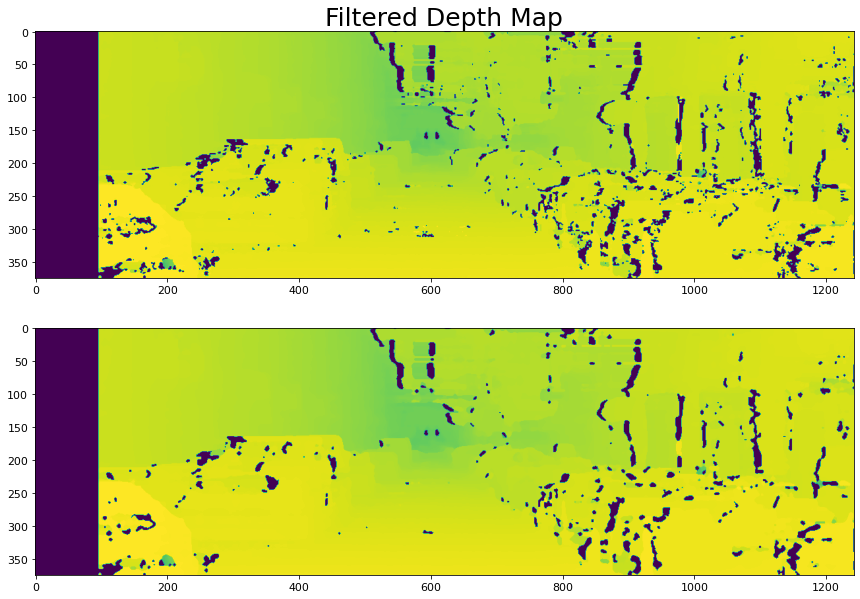

In [ ]:
filtered_depth_map = cv2.medianBlur(depth_map, 5)

_, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].imshow(np.log(depth_map), cmap='viridis_r')
ax[0].set_title('Original Depth Map', size=25)
ax[1].imshow(np.log(filtered_depth_map), cmap='viridis_r')
ax[0].set_title('Filtered Depth Map', size=25);

We can see that with a Median Blur filter some of the nosie is reduced and we still differentiate the edges of different distant objects.

## **Time for Object detection!**

Now let's run an object detector on our image and then we can see how far away each object is. We will use YOLOv5 to get the job done. For more information on YOLO or object detection in general I invite you to go through this excellent series of [blog posts](https://pyimagesearch.com/2022/04/04/introduction-to-the-yolo-family/).

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12034, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 12034 (delta 0), reused 1 (delta 0), pack-reused 12029
Receiving objects: 100% (12034/12034), 12.46 MiB | 26.91 MiB/s, done.
Resolving deltas: 100% (8274/8274), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-28 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

#### Reload images and detect objects

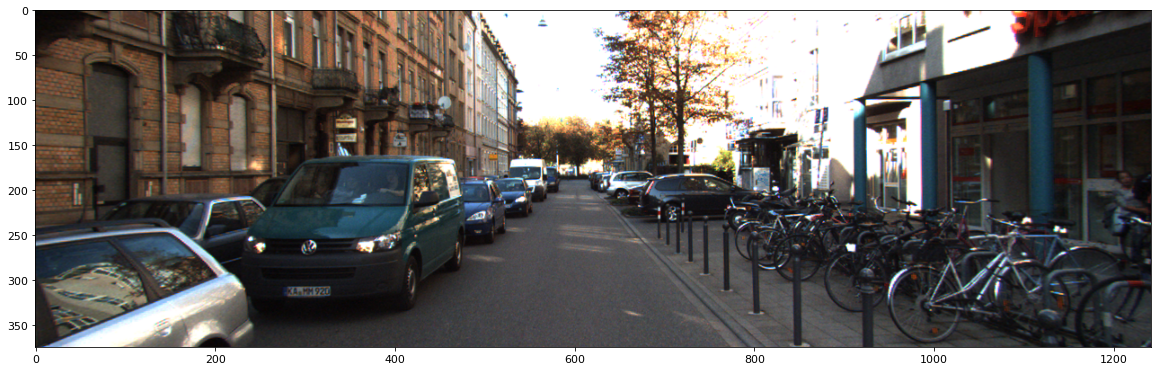

In [ ]:
left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
plt.imshow(left_image);

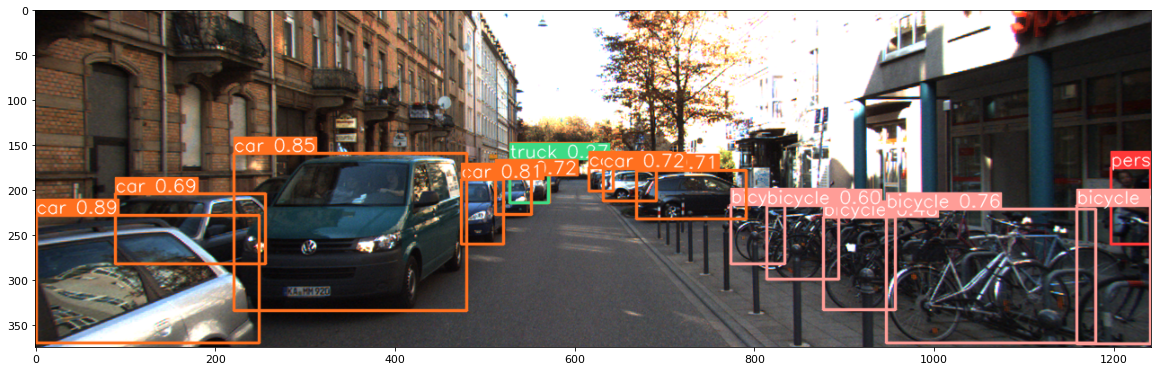

In [ ]:
detections = model(left_image)

detections.show() # draw boxes on image
plt.imshow(left_image);

Now we want to find the depth of each detected object. To do this we will follow these steps:
- Obtain coordinates for all bounding boxes
- Get Depth Slices i.e. Slice Depth array to contains pixels corresponding to each bounding box
- Get a depth for each object in meters
  - Use median or center of depth slice to obtain depth value

There are several ways to get the depth of a detected object from it's boxed depth area: mean, center coordinate, median, min, max. Imperfections in the detector disqualify methods such as min, max, and mean. This is because the boxed area may contain other objects that are very close or further away (typically occurs in the corners). This leaves the center and the median. The center of a depth slice is typically accurate, however the depth map slice is prone to noise and may greatly throw off the depth measurement. We will opt for the median of the boxed depth area which typically provides stable results if the bounding box is large enough.

In [ ]:
def get_distances(image, depth_map, bboxes, method='median', draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
        '''
    for bbox in bboxes:
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()
        
        # get center location on image
        x_center = np.round((pt1[1] + pt2[1]) / 2).astype(int)
        y_center = np.round((pt1[0] + pt2[0]) / 2).astype(int)

        # get depth slice
        depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]

        # compute median depth to get the distance
        if method == 'center':
            x_c = np.round((pt2[1] - pt1[1]) / 2).astype(int)
            y_c = np.round((pt2[0] - pt1[0]) / 2).astype(int)
            stereo_depth = depth_slice[x_c, y_c]
        else:
            stereo_depth = np.median(depth_slice)

        # draw depth on image at center of each bounding box
        if draw:
            cv2.putText(image, 
                        '{0:.2f} m'.format(stereo_depth), 
                        (y_center, x_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
        
    return image


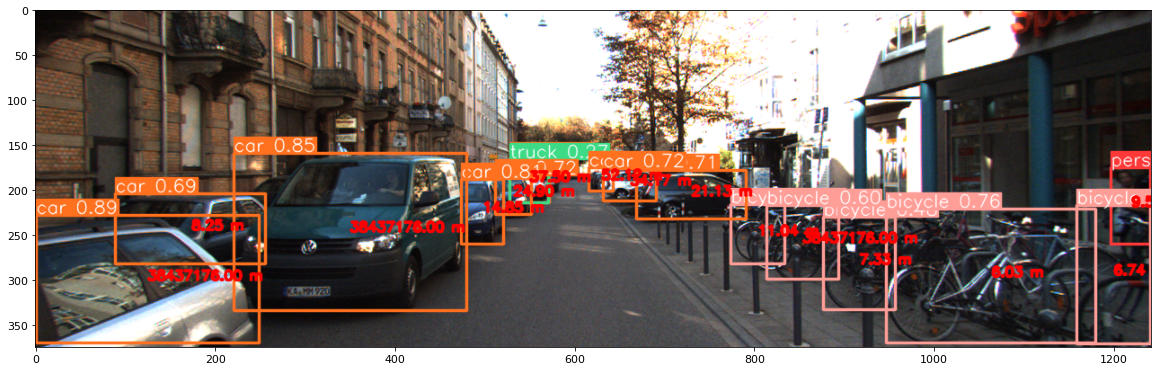

In [ ]:
# get distance measurements for image
distance_image = left_image.copy()

# get bounding box locations (x1,y1), (x2,y2) Prob, class
bboxes = detections.xyxy[0]

distance_image = get_distances(distance_image, filtered_depth_map, bboxes, method='center')
plt.imshow(distance_image);

Using the center metric looks okay for most objects. The object in the bottom left receives a rediculously high depth estimate. This is likely noise from our block matching alogirithm, this noise can be tuned away with hyper parameter adjustments, it could be filtered (beyond the median filter we already applied), or we could use [deep learning based matching methods](https://learnopencv.com/disparity-estimation-using-deep-learning/) to find the disparity instead. For now we will live with it and use the median as our distance metric.

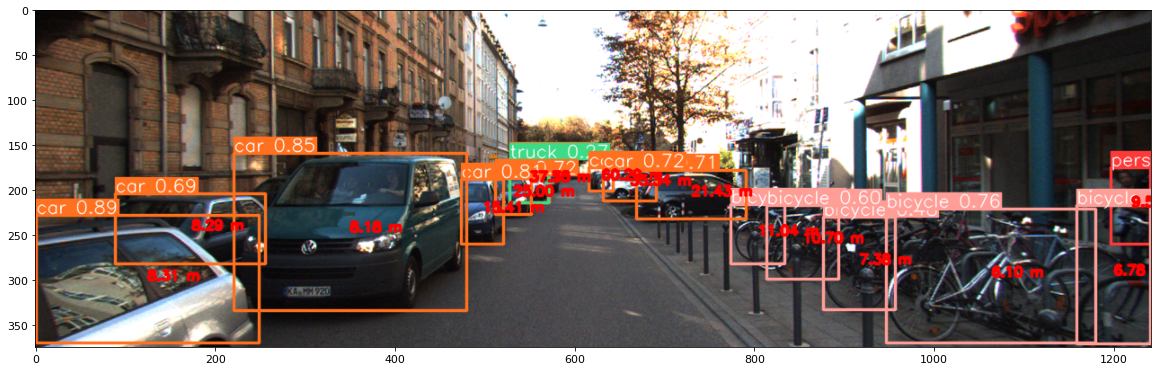

In [ ]:
# get distance measurements for image
distance_image = left_image.copy()

distance_image = get_distances(distance_image, filtered_depth_map, bboxes, method='median')
plt.imshow(distance_image);

Much better! Every object seems to have a reasonable depth estimate. Now let's define a full pipeline that will allow us to compute the depth for objects in any RGB stereo image pair.

In [ ]:
def get_depth_detections(left_image, right_image, method='median', 
                         draw_boxes=True, draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    # convert to grayscale
    left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
    right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

    ## 1. compute left disparity map
    disparity = compute_sgbm_disparity(left_image_gray, 
                                       right_image_gray, 
                                       num_disparities=96, 
                                       block_size=7, 
                                       window_size=7)

    ## 2. compute left depth map
    depth_map = calc_depth_map(disparity, K_left, T_left, T_right)

    # filter depth map
    filtered_depth_map = cv2.medianBlur(depth_map, 5)

    ## 3. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get distance measurements for image
    left_image = get_distances(left_image, 
                               filtered_depth_map, 
                               bboxes, 
                               method, 
                               draw_depth)

    return left_image, filtered_depth_map, bboxes

You may have noticed that we are using the left image a lot, and that's because opencv's functions to compute the disparity are written for the left image only. If we wanted to do the same thing for the right image, it would require some extra work. Now let's test the pipeline!

In [ ]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

result, depth_map, _ = get_depth_detections(left_image, right_image, method='median')

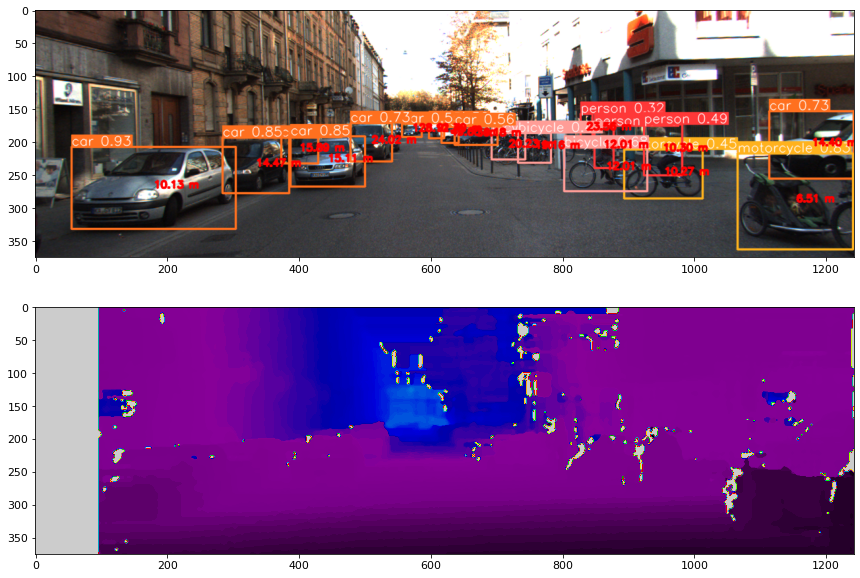

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[0].imshow(result);
ax[1].imshow(np.log(depth_map), cmap='nipy_spectral');

## **Now Let's Finally Make Some Videos!**

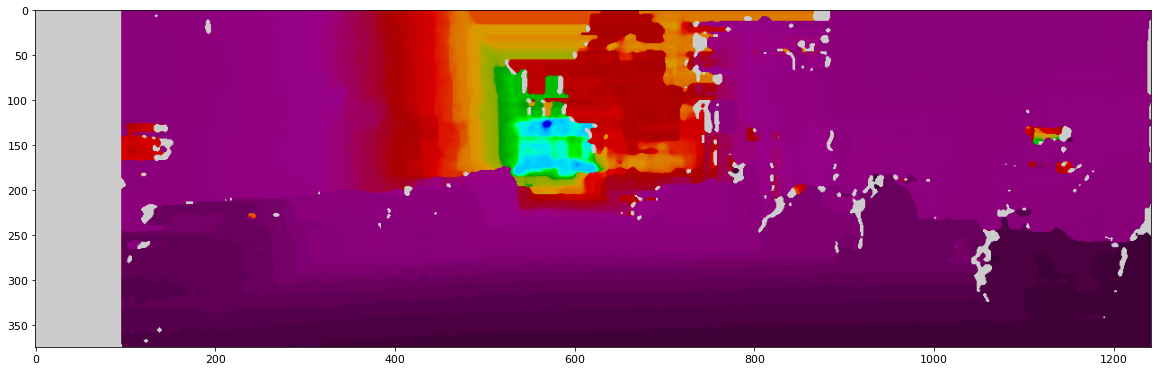

In [ ]:
from matplotlib import cm

# get color map function
nipy_spectral = cm.get_cmap('nipy_spectral') 

sample = (255*nipy_spectral(depth_map.round().astype(int))).astype(np.uint8)
sample = sample[:, :, ::-1][:, :, 1:] # reverse to rgb and remove transparency

plt.imshow(sample); 

In [ ]:
result_video = []

for idx in range(len(left_image_paths)):

    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)

    left_image, depth_map, _ = get_depth_detections(left_image, 
                                                    right_image, 
                                                    method='median', 
                                                    draw_boxes=True, 
                                                    draw_depth=True)

    # get depth map
    depth_map = (255*nipy_spectral(depth_map.round().astype(int))).astype(np.uint8)

    # reverse to rgb and remove transparency
    depth_map = depth_map[:, :, ::-1][:, :, 1:] 

    # stack frames
    stacked = np.vstack((left_image, depth_map))
    
    # append to video list
    result_video.append(stacked)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxes_depth_stack_2011_09_26.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

## **Now let's run the pipeline on another sample of KITTI data!**

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-08-28 17:47:10--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.73
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  31.6MB/s    in 94s     

2022-08-28 17:48:45 (31.5 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-08-28 17:48:45--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.125
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-28 17:48:46 (28.9 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [ ]:
!jar xf 2011_10_03_calib.zip

### Get the calibration data

In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

In [ ]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

#### Get left and right iamge paths

In [ ]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")

Number of left images: 837
Number of right images: 837


## **Now let's run the data through the pipeline and make a video!**

In [ ]:
result_video = []

for idx in range(len(left_image_paths)):

    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)

    left_image, depth_map, _ = get_depth_detections(left_image, 
                                                    right_image, 
                                                    method='median', 
                                                    draw_boxes=True, 
                                                    draw_depth=True)

    # get depth map
    depth_map = (255*nipy_spectral(depth_map.round().astype(int))).astype(np.uint8)

    # reverse to rgb and remove transparency
    depth_map = depth_map[:, :, ::-1][:, :, 1:] 

    # stack frames
    stacked = np.vstack((left_image, depth_map))
    
    # append to video list
    result_video.append(stacked)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxes_depth_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

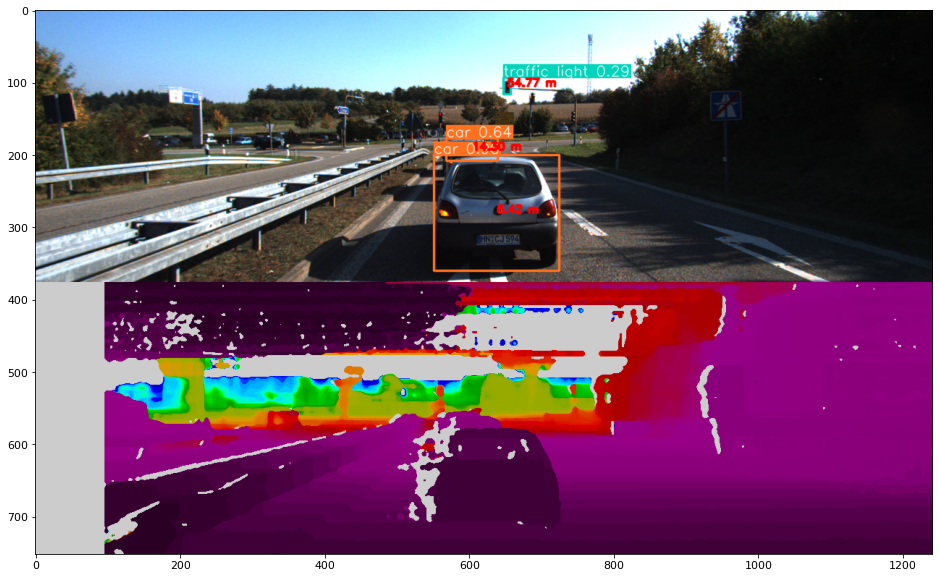

In [ ]:
plt.imshow(stacked);

## **That's it!**
If you've made it this far congratulations! You have learned to to compute depth from stereo images and make some cool videos!

Feel free to play around with the code and explore some more. In the next tutorial we will use LiDAR point clouds to see how accurate our depth computations are.